# Import Library

In [1]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Concatenate, Attention, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from gensim.models import FastText
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from Levenshtein import distance as levenshtein_distance

# Data Understanding

In [3]:
''''
Get The Data
'''

data = pd.read_csv('Sunda.csv')
data.head()

,pegon,latin
0,اِيࣤ,iyě
1,بَابْ,bab
2,مࣤرْتَيْلَاكࣤنْ,měrtelakěn
3,تَصَوُّفْ,taṣawwup
4,اَنَسُ,anasu


In [4]:
'''
Split Train and Testing Data
'''

train_df, test_df = train_test_split(data, test_size=0.1, random_state=42)

print("Shape of training set:", train_df.shape)
print("Shape of testing set:", test_df.shape)

Shape of training set: (3692, 2)
Shape of testing set: (411, 2)


# Data Preprocessing

In [5]:
def preprocess(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: '\t' + str(x).lower() + '\n')
    return df

In [6]:
'''
Convert to Lower Case and Add Start and End Token of the Latin Words
'''

train_df = preprocess(train_df, 'latin')
train_df.head()

,pegon,latin
1902,تَذَرُنَّ,\ttaḋarunna\n
1987,قَوْمِكَ,\tqomika\n
2843,ڮُسْتِيْ,\tgusti\n
56,مِسْكِينْ,\tmiskin\n
3990,أَرَيْكْ,\tarek\n


In [7]:
def train_fasttext_model(sentences, window=5, vector_size=300, epochs=150, min_count=0, sg=1):
    model = FastText(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        epochs=epochs,
        min_count=min_count,
        sg=sg
    )
    return model

In [8]:
def create_tokenizer(column_data):
    # Create a tokenizer for character-level tokenization
    tokenizer = Tokenizer(char_level=True)

    # Fit the tokenizer on the text data
    tokenizer.fit_on_texts(column_data)

    return tokenizer

In [9]:
def create_input_sequences(column_data, tokenizer):
    # Get the size of the vocabulary (number of unique characters) plus one for padding
    char_size = len(tokenizer.word_index) + 1

    # Encode the text data into sequences of integers
    encoded = tokenizer.texts_to_sequences(column_data)

    # Find the maximum sequence length
    max_len = max(len(seq) for seq in encoded)

    # Pad the sequences to ensure uniform length
    padded = pad_sequences(encoded, maxlen=max_len, padding='post')

    return char_size, encoded, max_len, padded

In [10]:
# Create Pegon Character Tokenizer
pegon_tokenizer = create_tokenizer(train_df['pegon'])

# Create Latin Character Tokenizer
latin_tokenizer = create_tokenizer(train_df['latin'])

In [11]:
# Create Input Sequences of Pegon Words
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(train_df['pegon'], pegon_tokenizer)

# Create Input Sequences of Latin Words
latin_char_size, latin_encoded, latin_max_len, padded_latin = create_input_sequences(train_df['latin'], latin_tokenizer)

In [12]:
'''
Save Tokenizer
'''

filename = 'pegon_tokenizer.pkl'
pickle.dump(pegon_tokenizer, open(filename, 'wb'))

filename = 'latin_tokenizer.pkl'
pickle.dump(latin_tokenizer, open(filename, 'wb'))

In [13]:
'''
Latin Token Index
'''

latin_index = latin_tokenizer.word_index
latin_df = pd.DataFrame(list(latin_index.items()), columns=['Char', 'Index'])
latin_df.set_index('Char', inplace=True)
latin_df

,Index
Char,
a,1
\t,2
\n,3
n,4
i,5
u,6
r,7
l,8
t,9


In [14]:
'''
Pegon Token Index
'''

pegon_index = latin_tokenizer.word_index
pegon_df = pd.DataFrame(list(pegon_index.items()), columns=['Char', 'Index'])
pegon_df.set_index('Char', inplace=True)
pegon_df

,Index
Char,
a,1
\t,2
\n,3
n,4
i,5
u,6
r,7
l,8
t,9


In [15]:
'''
Check All of Variables
'''

print("Number of characters in Pegon:", pegon_char_size)
print("Number of characters in Latin:", latin_char_size)

print()

print("Example of Encoded Pegon:", pegon_encoded[0])
print("Example of Encoded Latin:", latin_encoded[0])

print()

print("Max Length of Encoded Pegon Sequences:", pegon_max_len)
print("Max Length of Encoded Latin Sequences", latin_max_len)


print()

print("Example of Encoded Pegon with Padding:", padded_pegon[0])
print("Example of Encoded Latin with Padding:", padded_latin[0])

Number of characters in Pegon: 55
Number of characters in Latin: 45

Example of Encoded Pegon: [12, 1, 41, 1, 10, 6, 4, 23, 1]
Example of Encoded Latin: [2, 9, 1, 36, 1, 7, 6, 4, 4, 1, 3]

Max Length of Encoded Pegon Sequences: 20
Max Length of Encoded Latin Sequences 18

Example of Encoded Pegon with Padding: [12  1 41  1 10  6  4 23  1  0  0  0  0  0  0  0  0  0  0  0]
Example of Encoded Latin with Padding: [ 2  9  1 36  1  7  6  4  4  1  3  0  0  0  0  0  0  0]


In [16]:
'''
Train fastText model both Latin and Pegon
'''

vector_size = 300

pegon_vectorizer = train_fasttext_model(data['pegon'], vector_size)
latin_vectorizer = train_fasttext_model(data['latin'], vector_size)

In [17]:
def create_embedding_matrix(tokenizer, vectorizer):
    # Initialize embedding matrix
    char_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((char_size, vectorizer.vector_size))

    # Fill embedding matrix
    for char, i in tokenizer.word_index.items():
        embedding_vector = vectorizer.wv[char]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [18]:
'''
Create the Embedding Matrix for both Pegon and Latin
'''

pegon_emb_mat = create_embedding_matrix(pegon_tokenizer, pegon_vectorizer)
latin_emb_mat = create_embedding_matrix(latin_tokenizer, latin_vectorizer)


print("Example of Pegon Embedding Matrix:\n", pegon_emb_mat)
print("Example of Latin Embedding Matrix:\n", latin_emb_mat)

Example of Pegon Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.00654363  0.05121538  0.0258227  ...  0.0232883   0.01149928
  -0.00954635]
 [-0.02420046  0.07968245  0.00720069 ... -0.01132279 -0.05662589
  -0.04071059]
 ...
 [ 0.01466684 -0.0795845  -0.00874702 ...  0.00953474 -0.03705934
  -0.14814588]
 [-0.03873851  0.15079832  0.11312819 ...  0.09400477  0.00588221
  -0.09923423]
 [-0.13137053  0.13566345 -0.00622902 ... -0.05434028  0.10622439
   0.03076964]]
Example of Latin Embedding Matrix:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.03217554 -0.01514367  0.00748839 ... -0.01521664 -0.00889433
   0.03355211]
 [-0.00063902  0.00246553 -0.00065751 ...  0.00165612  0.0028372
  -0.00297938]
 ...
 [-0.1140028   0.02792316 -0.00844343 ...  0.08893947  0.09715287
   0.02161794]
 [-0.092242    0.1336253  -0.15277915 ... -0.01658925  0.00605278
  -0.12866765]
 [ 0.02508312  0.06258076  0.02470603 ...  

# Modelling

In [19]:
'''
Split Train and Validation Data
'''

X_train, X_val, y_train, y_val = train_test_split(padded_pegon, padded_latin, test_size=0.1, random_state=42)

print("Shape of Pegon Train:", X_train.shape)
print("Shape of Latin Train:", y_train.shape)
print("Shape of Pegon Validation:", X_val.shape)
print("Shape of Latin Validation:", y_val.shape)

Shape of Pegon Train: (3322, 20)
Shape of Latin Train: (3322, 18)
Shape of Pegon Validation: (370, 20)
Shape of Latin Validation: (370, 18)


In [20]:
def compile_model(model):
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

In [21]:
def create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [22]:
def create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, vector_size, weights=[pegon_emb_mat], trainable=False)(encoder_inputs)
    encoder_outputs, forward_h, backward_h = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, vector_size, weights=[latin_emb_mat], trainable=False)(decoder_inputs)
    decoder_outputs, _ = GRU(latent_dim*2, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [23]:
def create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
    encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Concatenate forward and backward states
    state_h_concat = Concatenate()([forward_h, backward_h])
    state_c_concat = Concatenate()([forward_c, backward_c])

    # Attention mechanism
    attention_layer = Attention()
    attention = attention_layer([encoder_outputs, state_h_concat])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h_concat, state_c_concat])

    # Apply attention
    context_vector = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenate context vector and decoder outputs
    decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile Model
    model = compile_model(model)

    return model

In [24]:
def create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, latent_dim=512):
    # Encoder
    encoder_inputs = Input(shape=(pegon_max_len,))
    encoder_embedding = Embedding(pegon_char_size, latent_dim)(encoder_inputs)
    encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
    encoder_outputs, forward_h, backward_h = encoder_gru(encoder_embedding)
    encoder_states = Concatenate()([forward_h, backward_h])

    # Decoder
    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(latin_char_size, latent_dim)(decoder_inputs)
    decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_states)

    # Attention mechanism
    attention = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate attention output and decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])

    # Dense layer to predict next token
    decoder_dense = Dense(latin_char_size, activation='softmax')(decoder_concat)

    # Model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense)

    # Compile Model
    model = compile_model(model)

    return model

In [25]:
def train_model(model, X_train, X_val, y_train, y_val, epochs=100, batch_size=64, patience=7):
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit([X_train, y_train[:, :-1]], y_train[:, 1:],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]),
                        callbacks=[early_stopping])

    training_time_seconds = time.time() - start_time
    training_time_minutes = training_time_seconds / 60.0
    print(f"Training time: {training_time_minutes:.2f} minutes")

    return model, training_time_minutes, history

## Create Model

In [26]:
'''
Create bilstm_att Seq2Seq Model
'''

bilstm_att = create_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bilstm_att.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 20, 512)              28160     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 20, 1024),           4198400   ['embedding[0][0]']           
 al)                          (None, 512),                                                    

In [27]:
'''
Create bigru_att Seq2Seq Model
'''

bigru_att = create_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size)
bigru_att.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 20, 512)              28160     ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  [(None, 20, 1024),           3151872   ['embedding_2[0][0]']         
 onal)                        (None, 512),                                                  

In [28]:
'''
Create fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att = create_fasttext_bilstm_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bilstm_att.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 20, 300)              16500     ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_2 (Bidirecti  [(None, 20, 1024),           3330048   ['embedding_4[0][0]']         
 onal)                        (None, 512),                                                  

In [29]:
'''
Create fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att = create_fasttext_bigru_attention_model(pegon_max_len, pegon_char_size, latin_char_size, pegon_emb_mat, latin_emb_mat)
fasttext_bigru_att.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 20)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 20, 300)              16500     ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional_3 (Bidirecti  [(None, 20, 1024),           2500608   ['embedding_6[0][0]']         
 onal)                        (None, 512),                                                  

## Training Model

In [30]:
'''
Train bilstm_att Seq2Seq Model
'''

bilstm_att, bilstm_att_training_time, bilstm_att_history = train_model(bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 12s 86ms/step - loss: 1.4520 - accuracy: 0.6395 - val_loss: 1.1208 - val_accuracy: 0.6963
Epoch 2/100
52/52 [==============================] - 2s 38ms/step - loss: 0.9973 - accuracy: 0.7301 - val_loss: 0.8197 - val_accuracy: 0.7830
Epoch 3/100
52/52 [==============================] - 2s 35ms/step - loss: 0.5476 - accuracy: 0.8652 - val_loss: 0.2663 - val_accuracy: 0.9404
Epoch 4/100
52/52 [==============================] - 2s 37ms/step - loss: 0.1744 - accuracy: 0.9602 - val_loss: 0.1158 - val_accuracy: 0.9741
Epoch 5/100
52/52 [==============================] - 2s 35ms/step - loss: 0.1123 - accuracy: 0.9732 - val_loss: 0.0751 - val_accuracy: 0.9831
Epoch 6/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0531 - accuracy: 0.9883 - val_loss: 0.0493 - val_accuracy: 0.9890
Epoch 7/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0364 - accuracy: 0.9918 - val_loss: 0.0232 - val_accuracy: 0.9944
Epoch

In [31]:
'''
Train bigru_att Seq2Seq Model
'''

bigru_att, bigru_att_training_time, bigru_att_history = train_model(bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 10s 76ms/step - loss: 1.4365 - accuracy: 0.6413 - val_loss: 1.0718 - val_accuracy: 0.7073
Epoch 2/100
52/52 [==============================] - 2s 35ms/step - loss: 0.7255 - accuracy: 0.8125 - val_loss: 0.2772 - val_accuracy: 0.9347
Epoch 3/100
52/52 [==============================] - 1s 29ms/step - loss: 0.1829 - accuracy: 0.9561 - val_loss: 0.0908 - val_accuracy: 0.9774
Epoch 4/100
52/52 [==============================] - 2s 32ms/step - loss: 0.0875 - accuracy: 0.9798 - val_loss: 0.0461 - val_accuracy: 0.9895
Epoch 5/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0373 - accuracy: 0.9920 - val_loss: 0.0253 - val_accuracy: 0.9951
Epoch 6/100
52/52 [==============================] - 2s 32ms/step - loss: 0.0248 - accuracy: 0.9943 - val_loss: 0.0317 - val_accuracy: 0.9938
Epoch 7/100
52/52 [==============================] - 1s 29ms/step - loss: 0.0334 - accuracy: 0.9923 - val_loss: 0.0221 - val_accuracy: 0.9943
Epoch

In [32]:
'''
Train fasttext_bilstm_att Seq2Seq Model
'''

fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history = train_model(fasttext_bilstm_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 9s 60ms/step - loss: 1.5514 - accuracy: 0.6165 - val_loss: 1.2047 - val_accuracy: 0.6693
Epoch 2/100
52/52 [==============================] - 2s 31ms/step - loss: 1.0870 - accuracy: 0.6984 - val_loss: 0.9410 - val_accuracy: 0.7323
Epoch 3/100
52/52 [==============================] - 2s 31ms/step - loss: 0.7669 - accuracy: 0.7937 - val_loss: 0.5552 - val_accuracy: 0.8574
Epoch 4/100
52/52 [==============================] - 2s 33ms/step - loss: 0.4043 - accuracy: 0.8969 - val_loss: 0.2517 - val_accuracy: 0.9374
Epoch 5/100
52/52 [==============================] - 2s 34ms/step - loss: 0.1982 - accuracy: 0.9502 - val_loss: 0.1386 - val_accuracy: 0.9709
Epoch 6/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0874 - accuracy: 0.9815 - val_loss: 0.1006 - val_accuracy: 0.9755
Epoch 7/100
52/52 [==============================] - 2s 32ms/step - loss: 0.0800 - accuracy: 0.9815 - val_loss: 0.0639 - val_accuracy: 0.9876
Epoch 

In [33]:
'''
Train fasttext_bigru_att Seq2Seq Model
'''

fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history = train_model(fasttext_bigru_att, X_train, X_val, y_train, y_val)

Epoch 1/100
52/52 [==============================] - 9s 47ms/step - loss: 1.5847 - accuracy: 0.6145 - val_loss: 1.1269 - val_accuracy: 0.6859
Epoch 2/100
52/52 [==============================] - 1s 26ms/step - loss: 0.8707 - accuracy: 0.7707 - val_loss: 0.5374 - val_accuracy: 0.8817
Epoch 3/100
52/52 [==============================] - 1s 26ms/step - loss: 0.3180 - accuracy: 0.9279 - val_loss: 0.1487 - val_accuracy: 0.9677
Epoch 4/100
52/52 [==============================] - 1s 25ms/step - loss: 0.1038 - accuracy: 0.9783 - val_loss: 0.0647 - val_accuracy: 0.9881
Epoch 5/100
52/52 [==============================] - 1s 27ms/step - loss: 0.0702 - accuracy: 0.9853 - val_loss: 0.0570 - val_accuracy: 0.9889
Epoch 6/100
52/52 [==============================] - 1s 28ms/step - loss: 0.0455 - accuracy: 0.9900 - val_loss: 0.0300 - val_accuracy: 0.9943
Epoch 7/100
52/52 [==============================] - 1s 27ms/step - loss: 0.0284 - accuracy: 0.9937 - val_loss: 0.0294 - val_accuracy: 0.9941
Epoch 

# Model Evaluation

In [34]:
def evaluate_model(model, X_val, y_val):
    evaluation_result = model.evaluate([X_val, y_val[:, :-1]], y_val[:, 1:])
    loss = evaluation_result[0]
    accuracy = evaluation_result[1]

    return loss, accuracy

In [35]:
'''
Evaluate Model
'''

models = {
    'bilstm_att': [bilstm_att, bilstm_att_training_time, bilstm_att_history],
    'bigru_att': [bigru_att, bigru_att_training_time, bigru_att_history],
    'fasttext_bilstm_att': [fasttext_bilstm_att, fasttext_bilstm_att_training_time, fasttext_bilstm_att_history],
    'fasttext_bigru_att': [fasttext_bigru_att, fasttext_bigru_att_training_time, fasttext_bigru_att_history]
}

evaluation_results = []

for model_name, values in models.items():
    model = values[0]
    training_time = values[1]
    history = values[2]
    loss, accuracy = evaluate_model(model, X_val, y_val)
    evaluation_results.append({
        'Model': model_name,
        'Loss': loss,
        'Accuracy': accuracy,
        'Epochs' : len(history.history['loss']),
        'Avg Training Time (m)': round(training_time/len(history.history['loss']), 2),
        'Total Training Time (m)': round(training_time, 2)
    })

evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df

12/12 [==============================] - 0s 9ms/step - loss: 0.0110 - accuracy: 0.9975


,Model,Loss,Accuracy,Epochs,Avg Training Time (m),Total Training Time (m)
0,bilstm_att,0.006065,0.998092,36,0.04,1.29
1,bigru_att,0.007649,0.998569,37,0.04,1.30
2,fasttext_bilstm_att,0.010794,0.997138,25,0.03,0.83
3,fasttext_bigru_att,0.011045,0.997456,34,0.03,0.91


In [36]:
def plot_loss_accuracy(model_name, history):
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history.get('val_loss', None)
    val_accuracy = history.history.get('val_accuracy', None)

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title(model_name + ' Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
    plt.title(model_name + ' Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

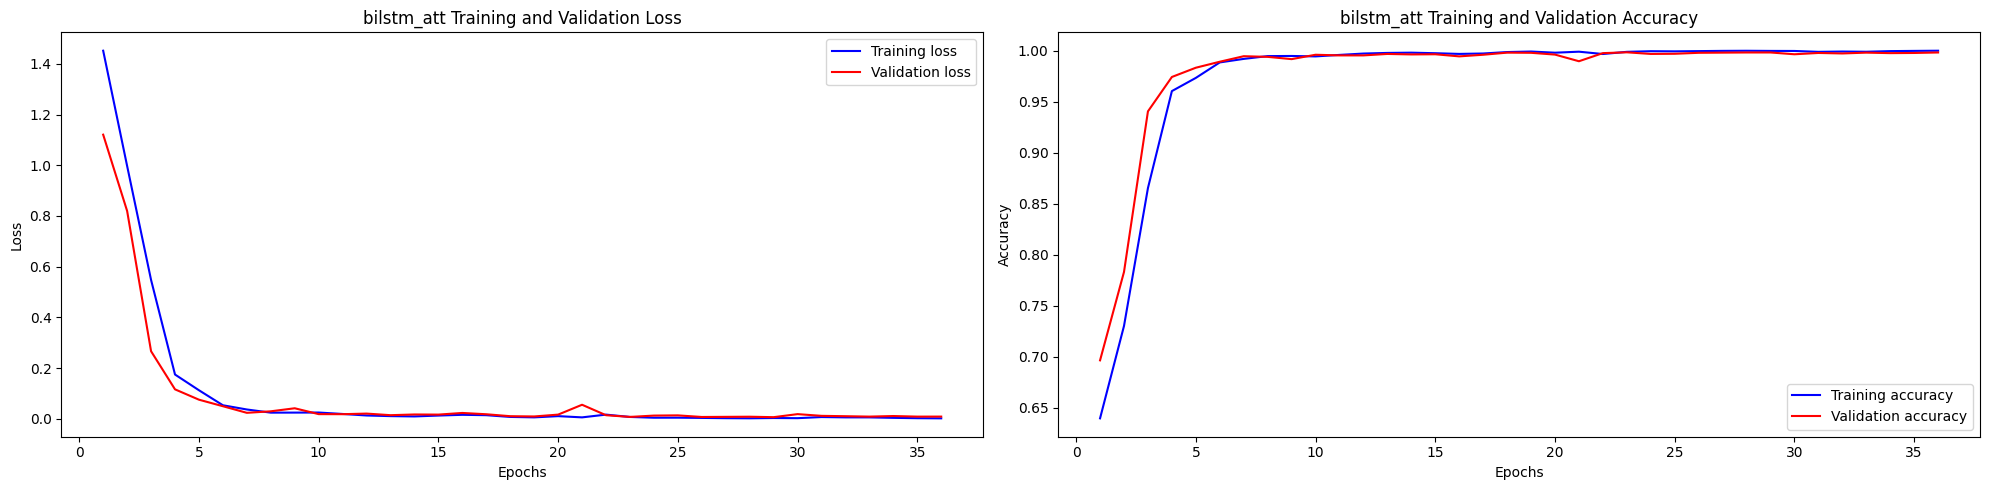

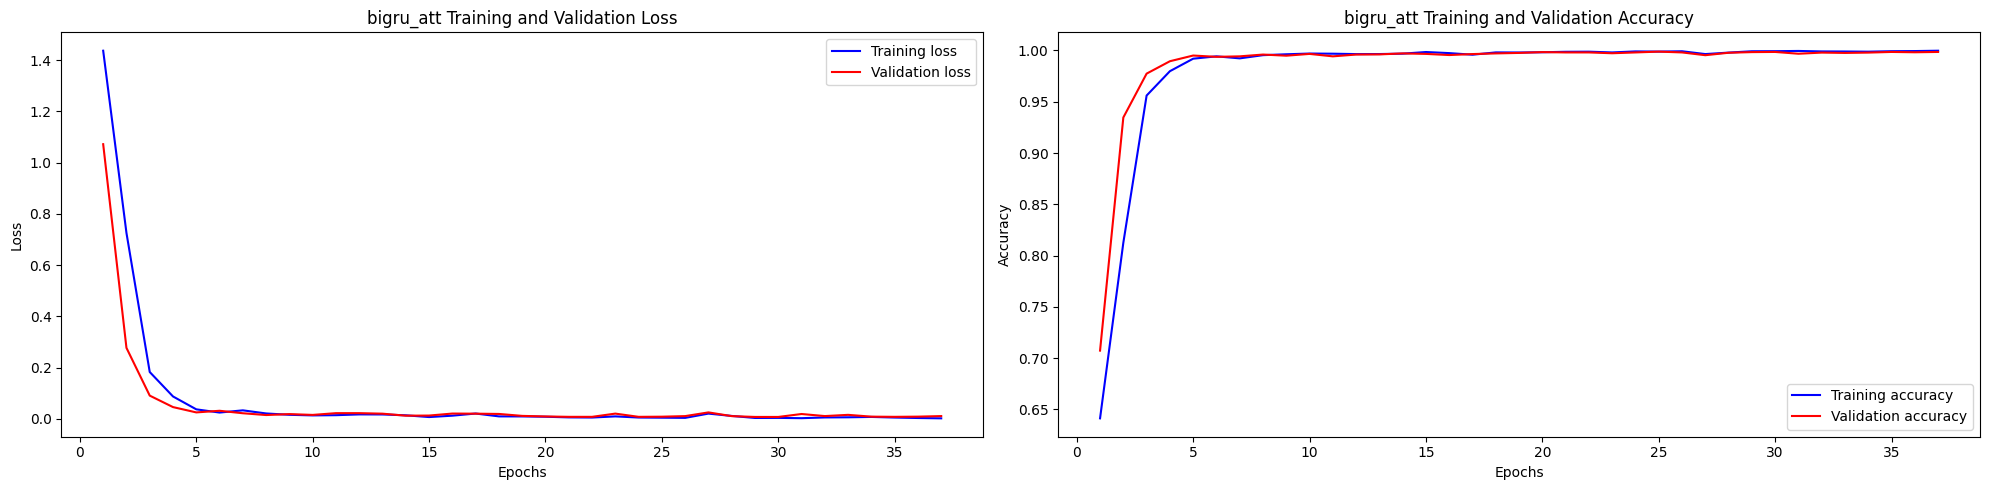

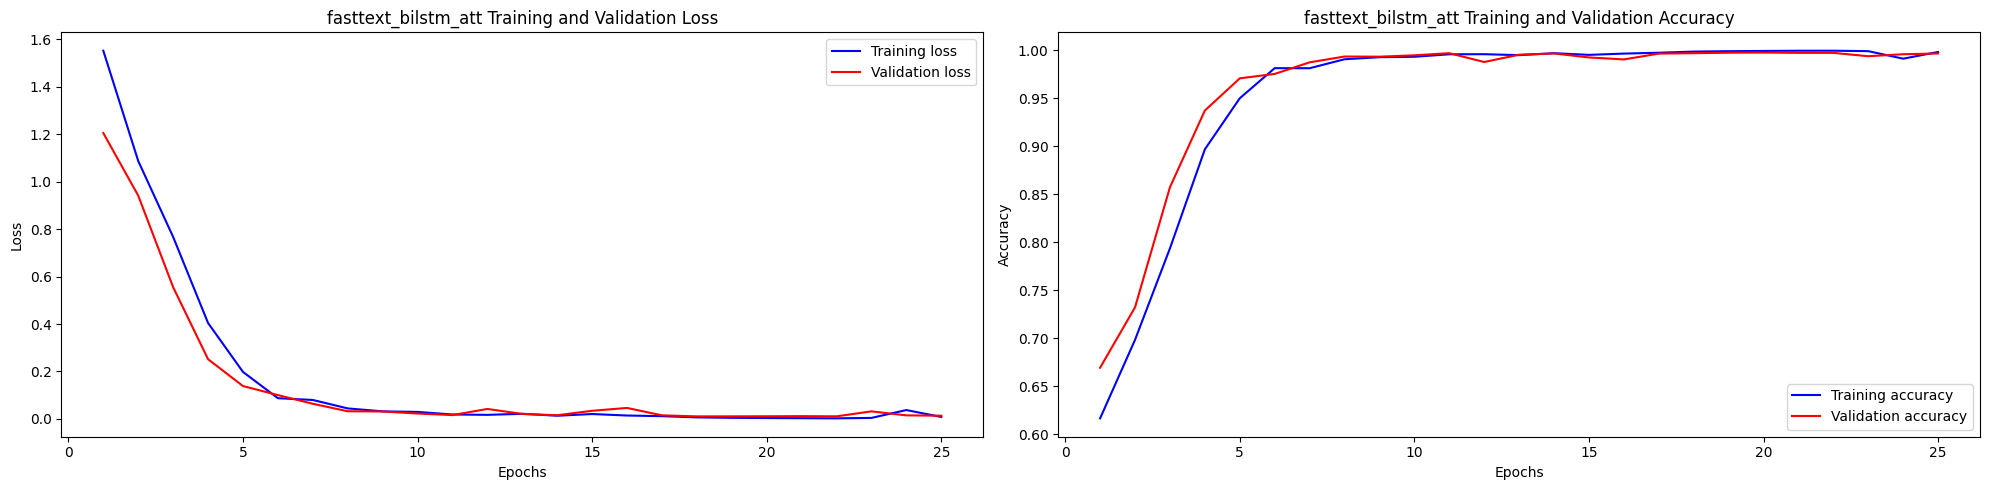

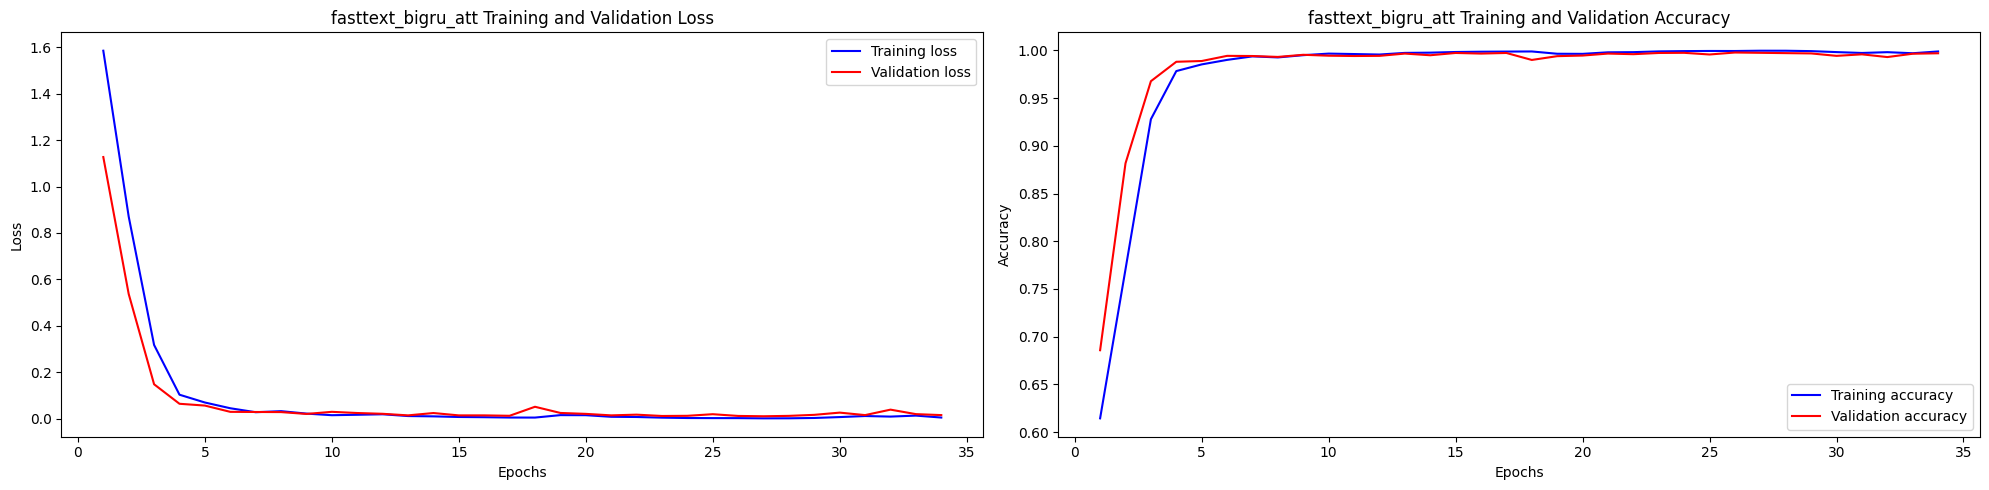

In [37]:
'''
Plot Accuracy and Loss
'''

histories = {
    'bilstm_att': bilstm_att_history,
    'bigru_att': bigru_att_history,
    'fasttext_bilstm_att': fasttext_bilstm_att_history,
    'fasttext_bigru_att': fasttext_bigru_att_history
}

for model_name, history in histories.items():
    plot_loss_accuracy(model_name, history)

In [38]:
'''
Save model
'''

filename = 'fasttext_bilstm_att.pkl'
pickle.dump(fasttext_bilstm_att, open(filename, 'wb'))

filename = 'fasttext_bigru_att.pkl'
pickle.dump(fasttext_bigru_att, open(filename, 'wb'))

filename = 'bilstm_att.pkl'
pickle.dump(bilstm_att, open(filename, 'wb'))

filename = 'bigru_att.pkl'
pickle.dump(bigru_att, open(filename, 'wb'))

In [39]:
def decode_output(decoder_input, tokenizer):
    output_seq = decoder_input[0, 1:-1]
    predicted_text = ""
    for index in output_seq:
        if index == 0:
            continue
        predicted_char = tokenizer.index_word.get(index, '')
        if predicted_char != ' ':
            predicted_text += predicted_char
    return predicted_text

In [40]:
def predict_latin(input_sequences, model, pegon_tokenizer, latin_tokenizer , pegon_max_length, latin_max_length):
    predictions = []
    for input_sequence in input_sequences:
        encoder_input = np.array([input_sequence])
        decoder_input = np.zeros((1, latin_max_length))
        decoder_input[0, 0] = latin_tokenizer.word_index['\t']

        for i in range(1, latin_max_length):
            pred = model.predict([[encoder_input], decoder_input], verbose=0)[0]
            predicted_token_index = np.argmax(pred[i-1])
            decoder_input[0, i] = predicted_token_index
            if predicted_token_index == latin_tokenizer.word_index['\n']:
                break

        predicted_text = decode_output(decoder_input, latin_tokenizer)
        predictions.append(predicted_text)
    return predictions

In [41]:
'''
Predict Data Train
'''

fasttext_bilstm_att_pred = predict_latin(X_val, fasttext_bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
fasttext_bigru_att_pred = predict_latin(X_val, fasttext_bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bilstm_att_pred = predict_latin(X_val, bilstm_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)
bigru_att_pred = predict_latin(X_val, bigru_att, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

# Error Analysis

In [42]:
'''
Get The Latin and Pegon of Data Train
'''

pegon_train, pegon_test, latin_train, latin_test = train_test_split(train_df['pegon'], train_df['latin'], test_size=0.1, random_state=42)

In [43]:
def calculate_cer(row):
    # Calculate Levenshtein distance between Ground Truth and Predicted strings
    distance = levenshtein_distance(row['Ground Truth'], row['Predicted'])

    # Calculate the length of the target (Ground Truth) string
    length = len(row['Ground Truth'])

    # Calculate CER (Character Error Rate) and handle the case when the length is 0
    return distance / length if length > 0 else np.nan

In [44]:
def create_cer_analysis(result_df):
    # Remove '\n' and '\t' from the dataframe
    result_df = result_df.replace(r'\n', '', regex=True).replace(r'\t', '', regex=True)

    # Calculate CER for each row
    result_df['CER'] = result_df.apply(calculate_cer, axis=1)

    # Calculate mean CER
    cer_mean = result_df['CER'].mean()

    # Filter rows with CER > 0
    error_result = result_df[result_df['CER'] > 0]

    return result_df, cer_mean, error_result

## BiLSTM-Att

In [45]:
'''
Calculate CER
'''

bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bilstm_att_pred
})

bilstm_att_result, bilstm_att_cer, bilstm_att_error_result = create_cer_analysis(bilstm_att_result)

print("Average CER: " + str(bilstm_att_cer))

Average CER: 0.005235072735072735


In [46]:
'''
Prediction Result
'''

bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
561,كُفُرْ,kupur,kupur,0.0
1495,أَحَدٍ,aẖadin,aẖadin,0.0
1164,وَّ,wwa,wwa,0.0
2096,تَكُنْ,takun,takun,0.0
210,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
322,سَلَهْنَا,salahna,salahna,0.0
2959,فِتُودُهْ,pituduh,pituduh,0.0
1866,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
3723,ۑَوْبِيْ,ñobi,ñobi,0.0


In [47]:
'''
Error Result
'''

bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
2124,بَيْنَهُمَا,benahuma,bainahuma,0.250000
2030,ڠَاؼࣤهْؼࣤيْكࣤنْ,ṅagěhgěikěn,ṅagěhgěik,0.181818
2931,سريرَيْيَا,srirea,srerea,0.166667
2933,برهلا,brhala,bbrala,0.333333
2929,فنجوڠ,pnjuṅ,panjuṅ,0.200000
2805,الْآفِلِيْنَ,al-āpilina,al-āpina,0.200000
2410,لِيُنْذِرَكُمْ,liyunḋirakum,liunḋirakum,0.083333
2249,الْبَشَرْ,al-baśar,al-bośar,0.125000
1540,ۑَرَاهَوْئَنْ,ñaraoan,ñarahoan,0.142857
770,الْأَلْبَابِ,al-albabi,al-al-babi,0.111111


## BiGRU-Att

In [48]:
bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': bigru_att_pred
})

bigruatt_result, bigru_att_cer, bigru_att_error_result = create_cer_analysis(bigru_att_result)

print("Average CER: " + str(bigru_att_cer))

Average CER: 0.00703024453024453


In [49]:
'''
Prediction Result
'''

bigruatt_result

,Pegon,Ground Truth,Predicted,CER
561,كُفُرْ,kupur,kupur,0.0
1495,أَحَدٍ,aẖadin,aẖadin,0.0
1164,وَّ,wwa,wwa,0.0
2096,تَكُنْ,takun,takun,0.0
210,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
322,سَلَهْنَا,salahna,salahna,0.0
2959,فِتُودُهْ,pituduh,pituduh,0.0
1866,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
3723,ۑَوْبِيْ,ñobi,ñobi,0.0


In [50]:
'''
Error Result
'''

bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
2042,جَآءَ,jā`a,jaā`a,0.250000
2931,سريرَيْيَا,srirea,sirea,0.166667
2933,برهلا,brhala,brhla,0.166667
227,تَحَجُّدْنَا,taẖajjudna,taẖajrudna,0.100000
4073,جُئُوْهْ,juuh,ju`,0.500000
2936,سمبه,smbh,smbabh,0.500000
2424,الْخَلْقِ,al-ḵalqi,al-ḵalqalqi,0.375000
1540,ۑَرَاهَوْئَنْ,ñaraoan,ñarahoan,0.142857
406,كَيْڠِيڠْ,keṅiṅ,keṅ,0.400000


## fastText BiLSTM-Att

In [51]:
fasttext_bilstm_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bilstm_att_pred
})

fasttext_bilstm_att_result, fasttext_bilstm_att_cer, fasttext_bilstm_att_error_result = create_cer_analysis(fasttext_bilstm_att_result)

print("Average CER: " + str(fasttext_bilstm_att_cer))

Average CER: 0.008108644358644357


In [52]:
'''
Prediction Result
'''

fasttext_bilstm_att_result

,Pegon,Ground Truth,Predicted,CER
561,كُفُرْ,kupur,kupur,0.0
1495,أَحَدٍ,aẖadin,aẖadin,0.0
1164,وَّ,wwa,wwa,0.0
2096,تَكُنْ,takun,takun,0.0
210,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
322,سَلَهْنَا,salahna,salahna,0.0
2959,فِتُودُهْ,pituduh,pituduh,0.0
1866,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
3723,ۑَوْبِيْ,ñobi,ñobi,0.0


In [53]:
'''
Error Result
'''

fasttext_bilstm_att_error_result

,Pegon,Ground Truth,Predicted,CER
2042,جَآءَ,jā`a,jaā`a,0.250000
1465,سُلَيْمَانَ,sulaimana,sulemana,0.222222
3823,ڮُيُوْرْ,guyur,guur,0.200000
280,كَااَللّٰهْ,kaallāh,kaallāhāh,0.285714
1597,مِّثْلَنَا,mmiṫlana,miṫlana,0.125000
2931,سريرَيْيَا,srirea,srreya,0.333333
2933,برهلا,brhala,brhll,0.333333
2929,فنجوڠ,pnjuṅ,panjuṅ,0.200000
3072,مࣤلࣤكࣤتࣤكْتࣤكْ,mělěkětěktěk,mělěkětěkěk,0.083333
1332,اللهَ,allāha,al-ha,0.333333


## fastText BiGRU-Att

In [54]:
fasttext_bigru_att_result = pd.DataFrame({
    'Pegon': pegon_test,
    'Ground Truth': latin_test,
    'Predicted': fasttext_bigru_att_pred
})

fasttext_bigruatt_result, fasttext_bigru_att_cer, fasttext_bigru_att_error_result = create_cer_analysis(fasttext_bigru_att_result)

print("Average CER: " + str(fasttext_bigru_att_cer))

Average CER: 0.007638352638352639


In [55]:
'''
Prediction Result
'''

fasttext_bigruatt_result

,Pegon,Ground Truth,Predicted,CER
561,كُفُرْ,kupur,kupur,0.0
1495,أَحَدٍ,aẖadin,aẖadin,0.0
1164,وَّ,wwa,wwa,0.0
2096,تَكُنْ,takun,takun,0.0
210,ڠَمَلْكࣤنْ,ṅamalkěn,ṅamalkěn,0.0
...,...,...,...,...
322,سَلَهْنَا,salahna,salahna,0.0
2959,فِتُودُهْ,pituduh,pituduh,0.0
1866,إِخْرَاجًا,iḵrajan,iḵrajan,0.0
3723,ۑَوْبِيْ,ñobi,ñobi,0.0


In [56]:
'''
Error Result
'''

fasttext_bigru_att_error_result

,Pegon,Ground Truth,Predicted,CER
3346,بَيْتُ,betu,baitu,0.500000
2042,جَآءَ,jā`a,jaā`a,0.250000
3767,افْعَلْ,ap'al,ap-'al,0.200000
3823,ڮُيُوْرْ,guyur,guur,0.200000
1597,مِّثْلَنَا,mmiṫlana,miṫlana,0.125000
2931,سريرَيْيَا,srirea,serea,0.333333
2933,برهلا,brhala,brhla,0.166667
2929,فنجوڠ,pnjuṅ,panjuṅ,0.200000
3072,مࣤلࣤكࣤتࣤكْتࣤكْ,mělěkětěktěk,mělěkětěk,0.250000
1540,ۑَرَاهَوْئَنْ,ñaraoan,ñarahoan,0.142857


## CER Compare

In [57]:
cer_result = pd.DataFrame({
    'Model': ['bilstm_att', 'bigru_att', 'fasttext_bilstm_att', 'fasttext_bigru_att'],
    'CER': [bilstm_att_cer, bigru_att_cer, fasttext_bilstm_att_cer, fasttext_bigru_att_cer]
})

cer_result

,Model,CER
0,bilstm_att,0.005235
1,bigru_att,0.007030
2,fasttext_bilstm_att,0.008109
3,fasttext_bigru_att,0.007638


# Model Testing

In [63]:
pegon_char_size, pegon_encoded, pegon_max_len, padded_pegon = create_input_sequences(test_df['pegon'], pegon_tokenizer)

In [64]:
best_model = bigru_att
pred = predict_latin(padded_pegon, best_model, pegon_tokenizer, latin_tokenizer, pegon_max_len, latin_max_len)

In [65]:
result = pd.DataFrame({
    'Pegon': test_df['pegon'],
    'Ground Truth': test_df['latin'],
    'Predicted': pred
})

model_result, model_cer, model_error_result = create_cer_analysis(result)

print("Average CER: " + str(model_cer))

Average CER: 0.011984899393658517


In [66]:
model_result

,Pegon,Ground Truth,Predicted,CER
1295,فَلَيْنَا,palaina,palena,0.285714
3841,دَوْمْبَا,domba,domba,0.000000
2458,تࣤفَنْتࣤسْ,těpantěs,těpantěs,0.000000
2955,مُوجَا,muja,muja,0.000000
3715,سَبِيْلًا,sabilan,sabilan,0.000000
...,...,...,...,...
2620,فَدَ,pada,pada,0.000000
2858,لِيْلِنْدࣤكْ,lilinděk,lilinděk,0.000000
263,اُوْلَهْ,ulah,ulah,0.000000
1832,كࣤبَوْنْ,kěbon,kěbon,0.000000


In [67]:
model_error_result

,Pegon,Ground Truth,Predicted,CER
1295,فَلَيْنَا,palaina,palena,0.285714
1395,سَوْءَةَ,sau`ata,so`ata,0.285714
109,خبل,ḵbl,ḵḵbl,0.333333
8,اَلْحمْدُلِلّٰهِ,al-ẖamdulillāhi,al-ẖulilālāhi,0.266667
3633,كَعْبَةْ,ka'bah,ka'bat,0.166667
149,لِّيُرَوْا,lliyurau,lliyuro,0.250000
3332,أَفْئِدَةً,apidatan,apaidatan,0.125000
842,عَبْدِيْسَدَأَيَا,'abdisadaaya,'abdisadaaaya,0.083333
1735,اللَّهُ,allahu,al-lahu,0.166667
3349,مُوْڮِيْا,mugia,mugi,0.200000
